In [1]:
! ls
%cd ..
%cd ..
! ls

test.ipynb
/home/jovyan/Egor_C/REPOSITORIES/RATE/MemoryMaze
/home/jovyan/Egor_C/REPOSITORIES/RATE
MemoryMaze  README.md  VizDoom	 _vizdoom.ini	   wandb
RATE_GTrXL  TMaze_new  _vizdoom  requirements.txt


In [35]:
import numpy as np

import matplotlib.pyplot as plt
import os
import sys
sys.path.append("../")
sys.path.append("../../")
sys.path.append("../../../")

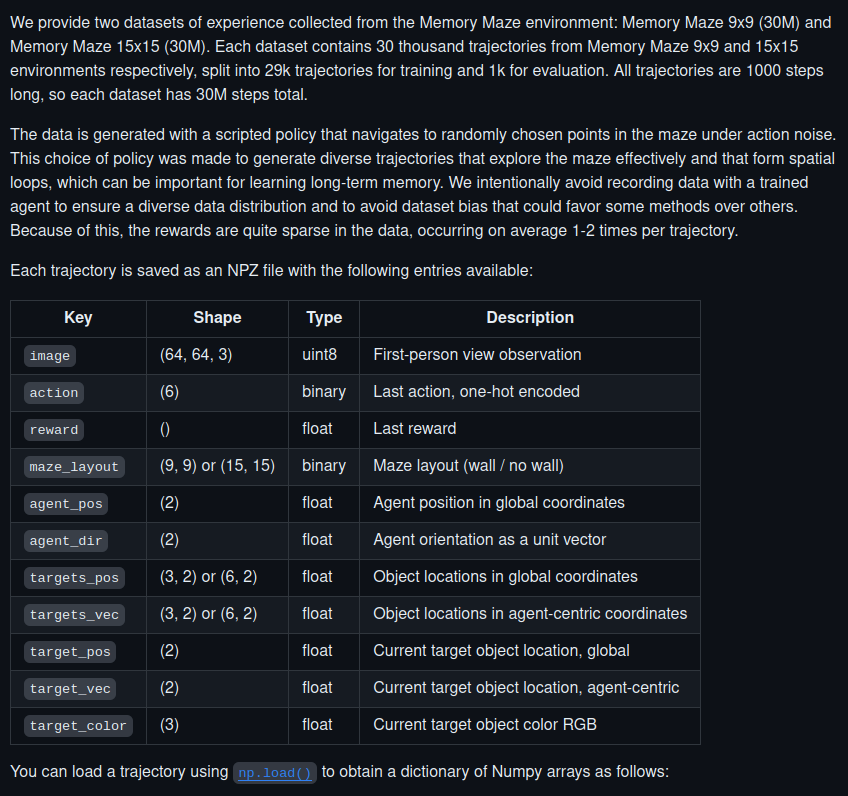

In [36]:
episode = np.load('MemoryMaze/MemoryMaze_data/9x9/20220923T110026-1000.npz')
episode = {key: episode[key] for key in episode.keys()}

assert episode['image'].shape == (1001, 64, 64, 3)
assert episode['image'].dtype == np.uint8

In [37]:
episode.keys()

dict_keys(['image', 'target_color', 'agent_pos', 'agent_dir', 'targets_vec', 'targets_pos', 'target_vec', 'target_pos', 'maze_layout', 'action', 'reward', 'terminal', 'reset'])

[0. 0. 1. 0. 0. 0.] 0.0


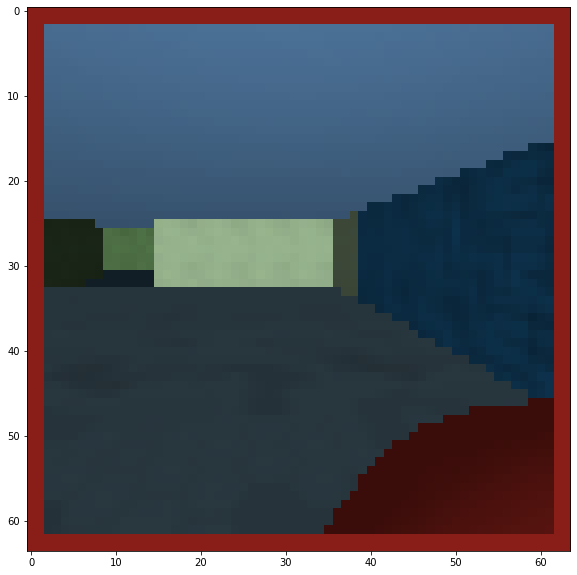

In [38]:
plt.figure(figsize=(10,10))
ind = 501
print(episode['action'][ind], episode['reward'][ind])
plt.imshow(episode['image'][ind])
plt.show()

In [148]:
from tqdm import tqdm

directory = 'MemoryMaze/MemoryMaze_data/9x9/'
file_list = os.listdir(directory)

rew_not_one = []

for file in tqdm(file_list):
    file_path = os.path.join(directory, file)
    data = np.load(file_path)
    
    rew_not_one += [int(any(data['reward'] > 0))]

100%|██████████| 2900/2900 [00:07<00:00, 381.60it/s]


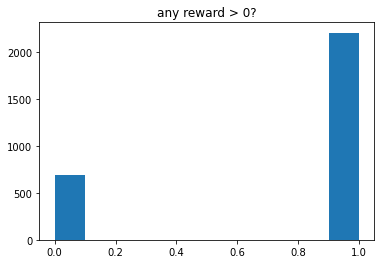

In [149]:
plt.hist(rew_not_one)
plt.title('any reward > 0?')
plt.show()

In [161]:
steps_with_rew = []

for file in tqdm(file_list):
    file_path = os.path.join(directory, file)
    data = np.load(file_path)
    
    positive_rewards = np.where(data['reward'] > 0)[0]
    steps_with_rew.extend(positive_rewards.tolist() if len(positive_rewards) > 0 else [-1])

100%|██████████| 2900/2900 [00:08<00:00, 344.89it/s]


In [205]:
lst2 = []
for el in steps_with_rew:
    if el != -1:
        lst2.append(el)
plt.hist(steps_with_rew)
plt.title('steps with reward distribution')
plt.show()

plt.hist(lst2)
plt.title('steps with reward distribution w/o 0')
plt.show()

In [191]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np

class MemoryMazeDataset(Dataset):
    def __init__(self, directory, gamma, max_length, only_non_zero_rewards):
        """_summary_

        Args:
            directory (str): path to the directory with data files
            gamma (float): discount factor
            max_length (int): maximum number of timesteps used in batch generation
                                (max in dataset: 1001)
            only_non_zero_rewards (bool): if True then use only trajectories
                                            with non-zero reward in the first
                                            max_length timesteps
        """
        self.directory = directory
        self.file_list = os.listdir(directory)
        self.gamma = gamma
        self.max_length = max_length
        self.only_non_zero_rewards = only_non_zero_rewards

    def discount_cumsum(self, x):
        """
        Compute the discount cumulative sum of a 1D array.

        Args:
            x (ndarray): 1D array of values.

        Returns:
            ndarray: Discount cumulative sum of the input array.
        """
        discount_cumsum = np.zeros_like(x)
        discount_cumsum[-1] = x[-1]
        for t in reversed(range(x.shape[0] - 1)):
            discount_cumsum[t] = x[t] + self.gamma * discount_cumsum[t+1]
        return discount_cumsum

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        file_path = os.path.join(self.directory, self.file_list[idx])
        data = np.load(file_path)

        image = torch.from_numpy(data['image']).permute(0, 3, 1, 2)
        action = torch.from_numpy(data['action'])
        # reward = torch.from_numpy(data['reward']).unsqueeze(-1)
        rtg = torch.from_numpy(self.discount_cumsum(data['reward'])).unsqueeze(-1)
        timesteps = torch.from_numpy(np.arange(0, self.max_length).reshape(-1))
        mask = torch.ones_like(timesteps)

        # print(image.shape, action.shape, rtg.shape, timesteps.shape, mask.shape)
        
        image = image[:self.max_length, :, :, :]
        action = action[:self.max_length, :]
        rtg = rtg[:self.max_length, :]
        mask = mask[:self.max_length]

        if self.only_non_zero_rewards:
            if any(data['reward'][:self.max_length]) > 0:
                return image, action, rtg, timesteps, mask
            
            return self.__getitem__(idx + 1)
        else:
            return image, action, rtg, timesteps, mask

# Assuming 'directory_path' is the path to the directory containing .npz files
dataset = MemoryMazeDataset('MemoryMaze/MemoryMaze_data/9x9/', gamma=1.0, max_length=1001, only_non_zero_rewards=True)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=4)


In [197]:
for batch in dataloader:
    x, a, rtg, timesteps, mask = batch
    print(x.shape, a.shape, rtg.shape, timesteps.shape, mask.shape)
    break

torch.Size([32, 1001, 3, 64, 64]) torch.Size([32, 1001, 6]) torch.Size([32, 1001, 1]) torch.Size([32, 1001]) torch.Size([32, 1001])


In [204]:
import torch
import torch.nn as nn
model =nn.Sequential(nn.Conv2d(3, 32, 8, stride=4, padding=0),
                    nn.ReLU(),
                    nn.Conv2d(32, 64, 4, stride=2, padding=0),
                    nn.ReLU(),
                    nn.Conv2d(64, 64, 3, stride=1, padding=0),
                    nn.ReLU(),
                    nn.Flatten(), nn.Linear(1024, 128),
                    nn.Tanh())   

B, B1, C, H, W = x.shape
print('x', x.shape)
x2 = x.view(-1, C, H, W).type(torch.float32).contiguous() 
print('x.view', x2.shape)
output = model(x2)
print(output.shape)

x torch.Size([32, 1001, 3, 64, 64])
x.view torch.Size([32032, 3, 64, 64])
torch.Size([32032, 128])
